<a href="https://colab.research.google.com/github/aashrat/stemtoshtem/blob/master/TransitTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We'll need to install the kplr package (documentation found here: http://dfm.io/kplr/). The lightkurve package is more commonly used (https://docs.lightkurve.org/tutorials/02-recover-a-planet.html), but it is less compatible with google colab.

In [15]:
pip install kplr

### Exoplanets
To find an exoplanet, I'd first recommend going to this page: https://en.wikipedia.org/wiki/List_of_exoplanets_discovered_using_the_Kepler_space_telescope and finding an exoplanet with a Wikipedia page. I'd recommend choosing a planet with only a b-component, but if you are interested in finding a multi-planet system, message me and I can help! Once you find your planet, go to https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative and type in the planet name under Kepler name. The column next to Kepler name will give you the planet's KOI name, which you will need later. Everything after the K and the 0's is the KOI number (ex. if the table says KOO752.01, the number is 752.01).


### Kepler 5b
Kepler 5b (https://en.wikipedia.org/wiki/Kepler-5b) is one of the first 5 confirmed exoplanets discovered by the Kepler mission. The discovery of Kepler 5b was announced in 2010. It is a hot Jupiter orbiting a subgiant star. (https://en.wikipedia.org/wiki/Kepler-5)


In [16]:
#importing necessary packages
#importing packages to handle math
import numpy as np
import math

#importing packages to store data in tables
import astropy
from astropy.table import Table
import pandas as pd

#importing plotting packages
import matplotlib
import matplotlib.pyplot as plt
#plotting inline
%matplotlib inline

#importing kplr package
import kplr

In the cell below, *only* change the koi number (here it is 18.01) and keep everything else the same.


In [17]:
#reading in kepler light curve
client = kplr.API()
koi = client.koi(18.01) # Find the target KOI, using your KOI number
lcs = koi.get_light_curves(short_cadence=False) # Get list of datasets.
f = lcs[0].open() # open the first light-curve dataset
hdu_data = f[1].data
time = hdu_data["time"] # get the time of each observation
flux = hdu_data["sap_flux"] # get the flux
flux_err = hdu_data["sap_flux_err"] # get the error in the flux
f.close()

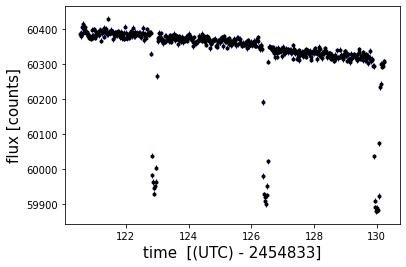

In [18]:
#plotting the lightcurve, this is what part of a light curve looks like!
plt.errorbar(time, flux,yerr=flux_err,fmt='.',linewidth=1,c='k',ecolor='b')

#label axes
plt.xlabel("time  [(UTC) - 2454833]",size=15)
plt.ylabel("flux [counts]",size=15)
plt.savefig('lightcurveraw.png')

In the cell below, you will need to change time values. There are more sophisticated methods, but we will be using visual inspection to detect transits. In the above plot, it is easy to see that the flux dips 3 times (between 122 and 124, between 126 and 128, and at around 130). Let's focus on the first transit.

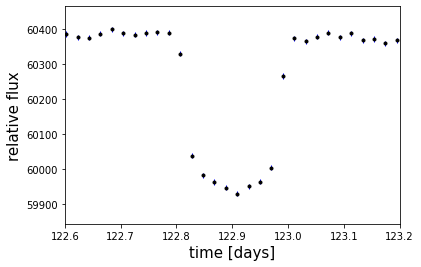

In [24]:
#zooming in on first transit by eye
plt.errorbar(time,flux,yerr=flux_err,fmt='.',linewidth=1,c='k',ecolor='b')
#change the xlim values to the time where you approximately think the transit is. play around with this
plt.xlim(122.6,123.2)

#labeling axes
plt.xlabel("time [days]",size=15)
plt.ylabel("relative flux", size=15)

plt.show()

We also want to normalize the flux. What this means is that the highest flux value we have is 1. There are more sophisticated values of doing this as well, but for simplicity, let's divide both the flux and the flux error by the maximum flux value we can see in the above plot. For me, this is about 60400. Change this value for your highest flux

In [29]:
normflux = flux/60400
normerr = flux_err/60400

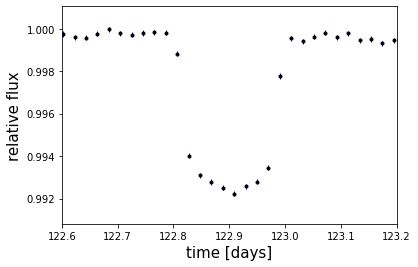

In [30]:
#plot the normalized flux and error
plt.errorbar(time,normflux,yerr=normerr,fmt='.',linewidth=1,c='k',ecolor='b')
#change the xlim values to the time where you approximately think the transit is. play around with this
plt.xlim(122.6,123.2)

#labeling axes
plt.xlabel("time [days]",size=15)
plt.ylabel("relative flux", size=15)

plt.show()

Now we need to define some variables based on our visual inspection and guessing!

In [35]:
#t0 is the middle time of the transit, where the flux is at its lowest point, 
#look at your own graph to guess this value
t0 = 122.9

#tau is half of the duration of the transit. Visually, it looks like the transit is lasting
#from between 122.8 to 123.0. So the duration is 0.2 and half of that is 0.1
tau = 0.1

#z is essentially our time normalized, don't change anything here
z = (time - t0)/tau

#this value is a pure guess. p actually refers to the ratio of the planet's radius divided
#by the star's radius, so if you want to calculate that from your background research,
#that will give you a better estimate. You can also just play around with this until you
#have a good fit
p = 0.078

The next few lines of code are functions to fit the transit with mathematical formulas. These formulas are shown below.
First we have the intensity function:
$$I(r) = 1 - (1 - \mu ^{1/2})$$
$$\mu = (1-r^2)^{1/2}$$

$$F(p,z) = \frac{\int_{0}^1I(r)[1-\delta(p,r,z)]2rdr}{\int_{0}^1I(r)2rdr}$$
$$\delta(p,r,z) = 
\begin{cases}
0 & r \geq z + p \\
1 & r + z \leq p \\
\pi^{-1}arccos[(z^2-p^2+r^2)/(2zr)] & \text{otherwise}
\end{cases}$$
Don't change any of these!

In [33]:
#define intensity function
def intensity(r):
    mu = (1 - r**2)**0.5
    return mu**0.5

#import integration
from scipy import integrate

#define delta function
def delta(p,r,z):
    abs(z)
    if r >= z + p or r <= z - p:
        return 0
    if r + z <= p:
        return 1
    d = math.acos((z**2 - p**2 + r**2)/(2*z*r))/(math.pi)
    return d

#define integrands
def numerator(r, p, z):
    return intensity(r)*(1 - delta(p,r,z))*2*r
def denominator(r, p, z):
    return intensity(r)*2*r

#define limbdarkening function
def limbdarkening(p, z):
    top = integrate.quad(numerator,0,1,args=(p,z))[0]
    bottom = integrate.quad(denominator,0,1,args=(p,z))[0] 
    return top/bottom

#define model
def model(p,tau,t0):
    z = (time - t0)/tau
    modelLD = []
    for Z in z:
        modelLD.append(limbdarkening(p,abs(Z)))
    return modelLD

Below, you will plot your flux values and compare this to the model. Don't change any lines of code below, but as you plot, go back to the cell with the variables p, tau, and t0 and change these values so the red line fits the points as best as possible. 

**If you're interested in a more robust technique, let me know and I can show you how to implement statistical tests to see how good of a fit this is. For now, don't worry about perfect accuracy.

Text(0, 0.5, 'normalized flux')

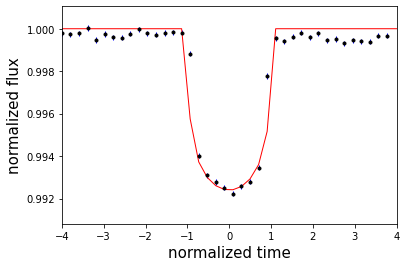

In [36]:
#plot actual flux values
plt.errorbar(z, normflux,normerr,fmt='.',linewidth=1,c='k',ecolor='b')
#focus in specifically on transit
plt.xlim(-4,4)

#plot model with limb darkening
plt.plot(z, model(p,tau,t0), c='r', lw=1)

#label axes
plt.xlabel("normalized time",size=15)
plt.ylabel("normalized flux", size=15)
#plt.savefig("transit1.png")

Hooray this looks like a great fit to me! Now we are going to take our final p-value and try to calculate the size of the planet. We know that its host star as a radius of 1.793 $R_\odot$, which is 1.793 solar radiuses. The sun is 696,340 km long. 

**Don't change the sunradius value, but change 1.793 to however many solar radiuses your planet's host star is.

In [37]:
sunradius = 696340
#change the value below
hoststar = 1.793 * sunradius

Now, let's use our p value to calculate the size of the planet and convert this to earth radiuses ($R_\oplus$)

In [38]:
exoplanetradius = hoststar * p
earthradius = 6378
exoplanetradius = exoplanetradius/earthradius
print(exoplanetradius)

15.269039567262462


We calculated that the exoplanet is 15 times bigger than earth and has a radius of 15.27 $R_\oplus$. This is super close to the true value of 15.55 $R_\oplus$, which we can see on the Wikipedia page!!

## Assignment
When you are finished, take one or more of the graphs you generated as well as the background information you found to create an image/video/powerpoint of the planet you found and your research methods. Put your final project in the google drive.